In [920]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp
from scipy.fft import fft, ifft, fftfreq
from scipy import constants
from sympy import *

In [921]:
plt.style.use('ggplot')

### Line Parameters

In [922]:
L = 0.01 # lenght of wire in meters
dL = 1000
mu_0 = constants.mu_0
omega = 10**9 # 1[GHz]  
Z_L = 1e3 # 1k ohms load
z_vals = np.linspace(0, L, dL)

## Spatial Reconstruction

In [923]:
E = 1e3
def Gamma(z):
    return 0.5*np.exp(-E*z)
def dGamma_dz(z):
    return 0.5*(-E)*np.exp(-E*z)

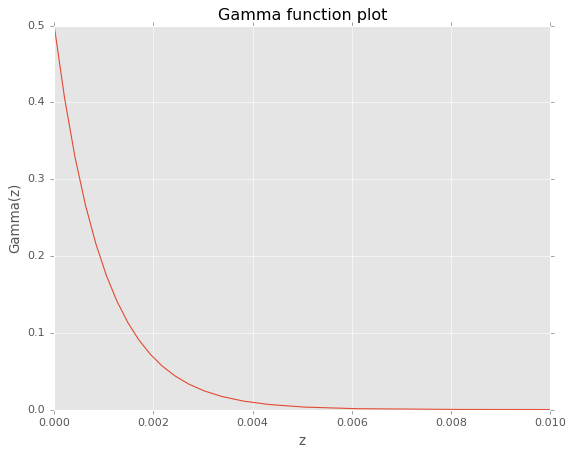

In [924]:
plt.plot(z_vals, Gamma(z_vals))
plt.xlabel('z')
plt.ylabel('Gamma(z)')
plt.title('Gamma function plot')
plt.show()

In [925]:
((np.sqrt(constants.mu_0)/Z_L)**2)/constants.epsilon_0

0.14192572923553196

### Derived Solution

In [926]:
def a(z):
    return -2 * dGamma_dz(z) * 1/(1-(Gamma(z))**2)
def b(z):
    return 4*omega*np.sqrt(mu_0) * (Gamma(z)/(1-(Gamma(z))**2))

In [927]:
def I(z):
    integrand = lambda x: -a(x)
    result, _ = quad(integrand, L, z)
    return np.exp(result)
# Compute the values of I(z) and the integrand
I_values = [I(z) for z in z_vals]
integrand_values = [I(z) * b(z) for z in z_vals]

# Compute the integral using numerical integration
integral_values = []
for i in range(len(z_vals)):
    integral, _ = quad(lambda x: I(x) * b(x), L, z_vals[i])
    integral_values.append(integral)

In [928]:
eps = [ ( (I_values[i])/( I_values[dL-1]*(Z_L/np.sqrt(mu_0)) + 1j*integral_values[i] ) )**2 for i in range(0, dL) ]

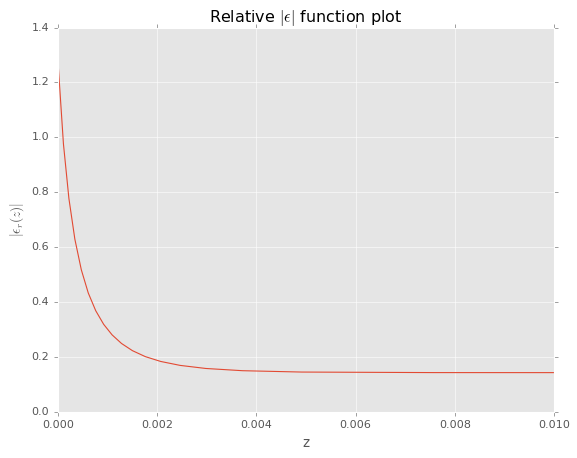

In [929]:
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in eps])
plt.xlabel('z')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Relative $|\epsilon|$ function plot')
plt.show()

### ODE Solution

In [930]:
def d_xi_dz(z, xi):
    return -a(z)*xi-b(z)*xi**2;

In [931]:
req_xi = odeint(d_xi_dz, y0=np.sqrt(eps[0].real), t=z_vals, tfirst=True)
req_eps = np.multiply(req_xi, req_xi)

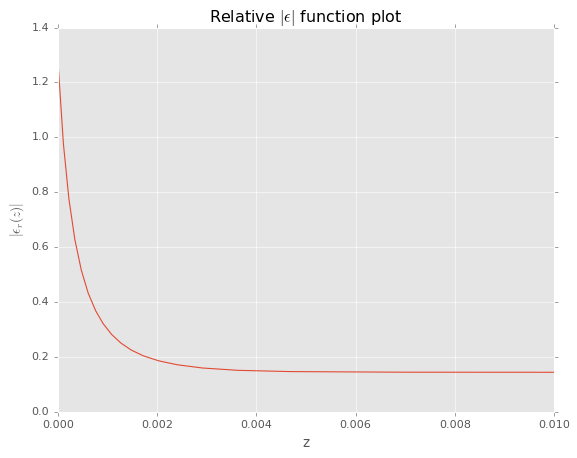

In [932]:
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in req_eps])
plt.xlabel('z')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Relative $|\epsilon|$ function plot')
plt.show()

### Comparison

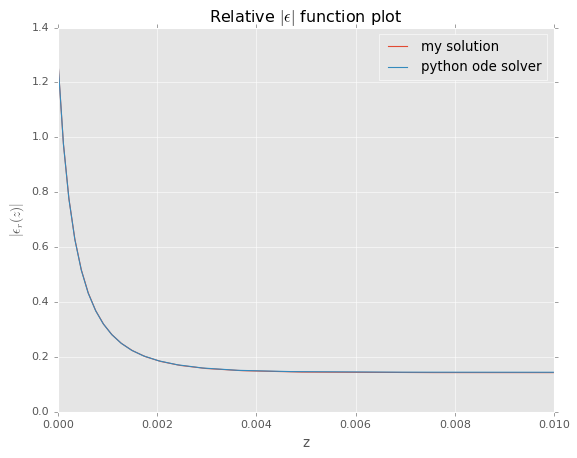

In [933]:
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in eps], label='my solution')
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in req_eps], label='python ode solver')
plt.xlabel('z')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Relative $|\epsilon|$ function plot')
plt.legend()
plt.show()

## Temporal Reconstruction

In [934]:
np.pi/omega

3.141592653589793e-09

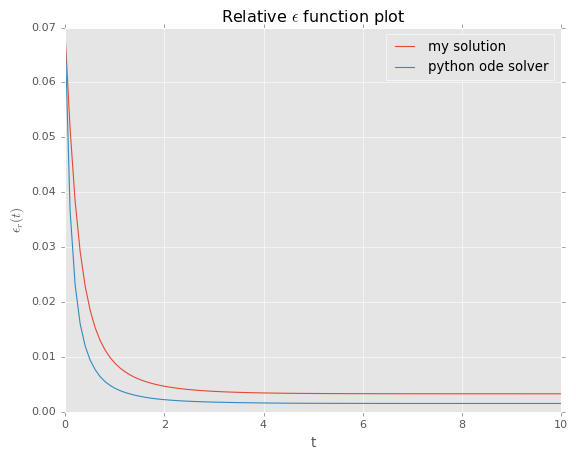

In [935]:
# Defining Gamma
def Gamma(t):
    return 0.5*np.exp(-1e0*t)
def dGamma_dt(t):
    return -0.5*(1e0)*np.exp(-1e0*t)
# defining a from hese values
def a(t):
    return -2 * dGamma_dt(t) * 1/(1-(Gamma(t))**2)
def b(t):
    return 4*omega*np.sqrt(mu_0) * (Gamma(t)/(1-(Gamma(t))**2))

# convert a and b to arrays
T = 10
t_vals = np.linspace(0, T, 100)

a_r = [a(t_val) for t_val in t_vals]
b_r = [b(t_val) for t_val in t_vals]
I = [ np.exp(-quad(a, 0, t_val)[0]) for t_val in t_vals ]

# We first find I(z)b(z) and we interpolate this function
d = [ (I[i]*b_r[i]) for i in range(0, 100) ]
d_interp = interp1d(np.linspace(0, T, 100), d, kind='cubic')
D = [ quad(d_interp, 0, t_val)[0] for t_val in t_vals ]

dGamma_dt_r = [dGamma_dt(t_val) for t_val in t_vals]

xi_0 = (a_r[0]-2*dGamma_dt_r[0])/b_r[0]

eps = [ ( (I[i])/( I[0]*( 1/xi_0  ) + 1j*D[i] ) )**2 for i in range(0, 100) ]


# defining a from hese values
def a(t):
    return -2 * dGamma_dt(t) * 1/(1-(Gamma(t))**2)
def b(t):
    return 4*omega*np.sqrt(mu_0) * (Gamma(t)/(1-(Gamma(t))**2))

def d_xi_dt(t, xi):
    return -a(t)*xi-b(t)*xi**2;

req_xi = odeint(d_xi_dt, y0=xi_0, t=t_vals, tfirst=True)
req_eps = np.multiply(req_xi, req_xi)

plt.plot(t_vals, [(abs(val)/constants.epsilon_0) for val in eps], label='my solution')
plt.plot(t_vals, [(abs(val)/constants.epsilon_0) for val in req_eps], label='python ode solver')
plt.xlabel('t')
plt.ylabel('$\epsilon_r(t)$')
plt.title('Relative $\epsilon$ function plot')
plt.legend()
plt.show()